In [1]:
!pip install numpy pandas sentencepiece scipy torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.4 MB/s eta 0:00:00


In [2]:
#importing python pakages
import numpy as np
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt


In [3]:

from keras.layers import Conv1D, Dense, Embedding, GlobalMaxPooling1D, LSTM
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

from tqdm import tqdm

from transformers import AlbertTokenizer, AlbertForSequenceClassification, BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, AdamW

from scipy.stats import zscore

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D


In [ ]:
# # Read the new dataset
# df_yelp = pd.read_csv("Yelp_Dataset.csv", encoding="utf-8", error_bad_lines=False)

# # Step 1: Drop rows with null or NaN values
# df_yelp = df_yelp.dropna()

# # Step 2: Remove empty strings and garbage characters in the 'Review' column
# df_yelp['Review'] = df_yelp['Review'].replace('', np.nan)
# df_yelp['Review'] = df_yelp['Review'].replace(r'[^a-zA-Z0-9\s]', '', regex=True)

# # Step 3: Convert text to lowercase
# df_yelp['Review'] = df_yelp['Review'].str.lower()

# # Step 4: Convert 'Date' to datetime format
# df_yelp['Date'] = pd.to_datetime(df_yelp['Date'], errors='coerce')

# # Step 5: Convert 'Rating' to numeric
# df_yelp['Rating'] = pd.to_numeric(df_yelp['Rating'], errors='coerce')

# # Step 6: Remove duplicates
# df_yelp = df_yelp.drop_duplicates()

# # Step 7: Handle outliers in 'Rating' using z-score
# df_yelp['Rating'] = zscore(df_yelp['Rating'])

# # Step 8: Drop unnecessary columns
# # columns_to_drop = ['User_id']   #Add other columns if needed
# # df_yelp = df_yelp.drop(columns=columns_to_drop, axis=1)

# # Step 9: Check data types
# print(df_yelp.dtypes)

# # Step 10: Explore the cleaned data
# print(df_yelp.describe(include='all'))

# # Rename columns
# df_yelp = df_yelp.rename(columns={'Review': 'Reviews', 'Label': 'Fake_review_flag'})

# # Replace values in the 'Fake_review_flag' column
# df_yelp['Fake_review_flag'] = df_yelp['Fake_review_flag'].replace(-1.0, 0)

# # Print the updated DataFrame
# print(df_yelp.head())

In [4]:
# # Load the dataset
df = pd.read_csv("./fake_reviews_dataset.csv")


data = df.sample(frac=1.0)

# Extracting Reviews and Labels
X = data["Reviews"]
y = data["Fake_review_flag"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Tokenizer for LSTM and CNN
max_features = 10000  # Number of words to consider as features
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences for LSTM and CNN
maxlen = 100  # Cuts off reviews after 100 words
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# TF-IDF for SVM
vectorizer = TfidfVectorizer(max_features=max_features)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [6]:
# Hyperparameters
batch_size = 32
epochs = 4

In [7]:
# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 128, input_length=maxlen))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation="sigmoid"))

# Compile the model
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
start_time_lstm = time.time()
# Train the model
lstm_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test))
end_time_lstm = time.time()
y_pred_lstm_classes = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")


# lstm_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test))
# end_time_lstm = time.time()

Epoch 1/4
1011/1011 [==============================] - 480s 466ms/step - loss: 0.2430 - accuracy: 0.8999 - val_loss: 0.1649 - val_accuracy: 0.9336
Epoch 2/4
1011/1011 [==============================] - 539s 534ms/step - loss: 0.1294 - accuracy: 0.9520 - val_loss: 0.1784 - val_accuracy: 0.9316
Epoch 3/4
1011/1011 [==============================] - 449s 444ms/step - loss: 0.0896 - accuracy: 0.9674 - val_loss: 0.1526 - val_accuracy: 0.9437
Epoch 4/4
253/253 [==============================] - 8s 31ms/step


In [8]:
accuracy_lstm = accuracy_score(y_test, y_pred_lstm_classes)
print(f"LSTM Model Accuracy: {accuracy_lstm}")

LSTM Model Accuracy: 0.9425003091381229


In [9]:
# Building the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(max_features, 128, input_length=maxlen))
cnn_model.add(Conv1D(64, 5, activation="relu"))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation="sigmoid"))

# Compile the model
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
start_time_cnn = time.time()
# Train the model
cnn_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test))
end_time_cnn = time.time()
y_pred_cnn_classes = (cnn_model.predict(X_test_pad) > 0.5).astype("int32")


# cnn_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_pad, y_test))
# end_time_cnn = time.time()

Epoch 1/4
1011/1011 [==============================] - 35s 28ms/step - loss: 0.2874 - accuracy: 0.8851 - val_loss: 0.1878 - val_accuracy: 0.9294
Epoch 2/4
1011/1011 [==============================] - 11s 11ms/step - loss: 0.1077 - accuracy: 0.9617 - val_loss: 0.1704 - val_accuracy: 0.9348
Epoch 3/4
1011/1011 [==============================] - 7s 7ms/step - loss: 0.0424 - accuracy: 0.9874 - val_loss: 0.1833 - val_accuracy: 0.9382
Epoch 4/4
253/253 [==============================] - 0s 2ms/step


In [10]:
accuracy_cnn = accuracy_score(y_test, y_pred_cnn_classes)
print(f"CNN Model Accuracy: {accuracy_cnn}")


CNN Model Accuracy: 0.9380487201681711


In [11]:
# Building and training the SVM model
svm_model = SVC(kernel="linear")
start_time_svm = time.time()
svm_model.fit(X_train_tfidf, y_train)
end_time_svm = time.time()
# Predicting and evaluating on the test set
y_pred_svm = svm_model.predict(X_test_tfidf)




In [12]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm}")

SVM Model Accuracy: 0.9063929763818475


In [13]:
# Predicting with LSTM model
y_pred_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm_classes = (y_pred_lstm > 0.5).astype("int32")

# Predicting with CNN model
y_pred_cnn = cnn_model.predict(X_test_pad)
y_pred_cnn_classes = (y_pred_cnn > 0.5).astype("int32")

# Evaluation for LSTM model
print("LSTM Model Evaluation")
print(classification_report(y_test, y_pred_lstm_classes))

# Evaluation for CNN model
print("CNN Model Evaluation")
print(classification_report(y_test, y_pred_cnn_classes))


# # Evaluate SVM
# print(f"SVM Model Accuracy: {accuracy_svm:.4f}")

253/253 [==============================] - 1s 2ms/step
LSTM Model Evaluation
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4040
           1       0.94      0.95      0.94      4047

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087

CNN Model Evaluation
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      4040
           1       0.93      0.94      0.94      4047

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087



In [14]:
# Evaluate models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(classification_report(y_true, y_pred))


In [ ]:
# Evaluate LSTM
evaluate_model(y_test, y_pred_lstm_classes, "LSTM")

# Evaluate CNN
evaluate_model(y_test, y_pred_cnn_classes, "CNN")

# Evaluate SVM
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Model Accuracy: {accuracy_svm:.4f}")

LSTM Model Evaluation:
Accuracy: 0.9448
Precision: 0.9449
Recall: 0.9448
F1 Score: 0.9449
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4087
           1       0.94      0.95      0.94      4000

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087

CNN Model Evaluation:
Accuracy: 0.9374
Precision: 0.9374
Recall: 0.9374
F1 Score: 0.9374
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4087
           1       0.94      0.93      0.94      4000

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087

SVM Model Accuracy: 0.9086


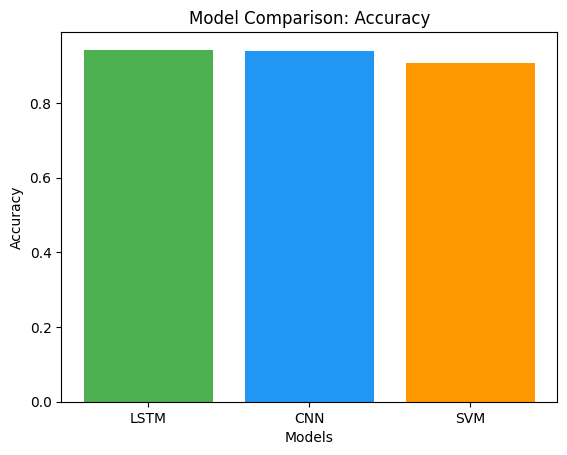

In [15]:
# Create a bar chart for accuracy
models = ['LSTM', 'CNN', 'SVM']
accuracies = [accuracy_score(y_test, y_pred_lstm_classes),
              accuracy_score(y_test, y_pred_cnn_classes),
              accuracy_svm]

plt.bar(models, accuracies, color=['#4CAF50', '#2196F3', '#FF9800'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.show()

In [16]:
# Compute computational times
lstm_training_time = end_time_lstm - start_time_lstm
cnn_training_time = end_time_cnn - start_time_cnn
svm_training_time = end_time_svm - start_time_svm

In [17]:
print(lstm_training_time)
print(cnn_training_time)
print(svm_training_time)

1945.915045261383
82.82335186004639
185.17635226249695


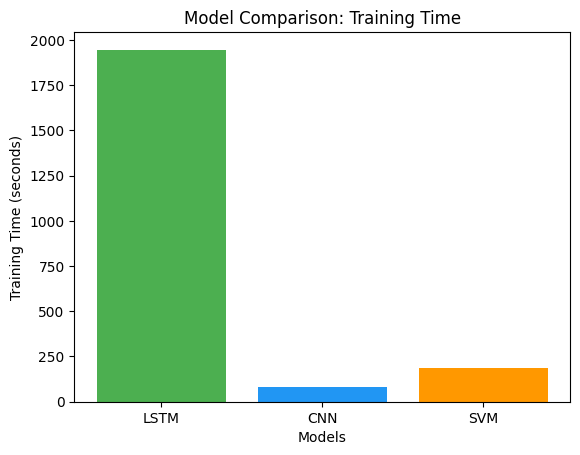

In [18]:
# Create a bar chart for computational time
training_times = [lstm_training_time, cnn_training_time, svm_training_time]

plt.bar(models, training_times, color=['#4CAF50', '#2196F3', '#FF9800'])
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Model Comparison: Training Time')
plt.show()

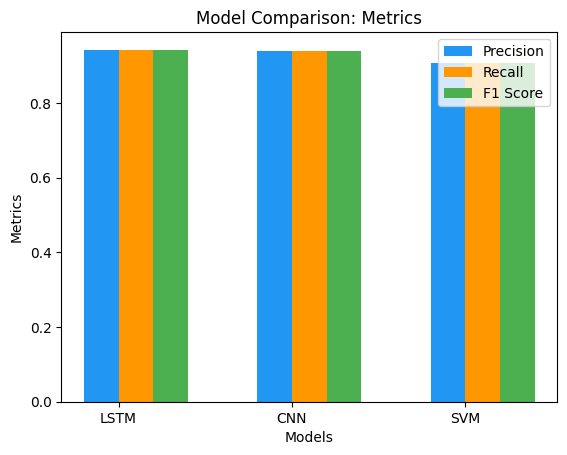

In [19]:
# Create a bar chart for precision, recall, and F1 score

# Evaluate models for precision, recall, and F1 score
def evaluate_metrics(y_true, y_pred, model_name):

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return {'Model': model_name, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}


# Evaluate LSTM metrics
lstm_metrics = evaluate_metrics(y_test, y_pred_lstm_classes, "LSTM")

# Evaluate CNN metrics
cnn_metrics = evaluate_metrics(y_test, y_pred_cnn_classes, "CNN")

# Evaluate SVM metrics
precision_svm, recall_svm, f1_svm, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')
svm_metrics = {'Model': 'SVM', 'Precision': precision_svm, 'Recall': recall_svm, 'F1 Score': f1_svm}

# Custom colors for the bars
colors = ['#4CAF50', '#2196F3', '#FF9800']

# Precision, Recall, and F1 Score values
precision_values = [lstm_metrics['Precision'], cnn_metrics['Precision'], svm_metrics['Precision']]
recall_values = [lstm_metrics['Recall'], cnn_metrics['Recall'], svm_metrics['Recall']]
f1_values = [lstm_metrics['F1 Score'], cnn_metrics['F1 Score'], svm_metrics['F1 Score']]

bar_width = 0.2
index = np.arange(len(models))

models = ['LSTM', 'CNN', 'SVM']
precision_values = [lstm_metrics['Precision'], cnn_metrics['Precision'], svm_metrics['Precision']]
recall_values = [lstm_metrics['Recall'], cnn_metrics['Recall'], svm_metrics['Recall']]
f1_values = [lstm_metrics['F1 Score'], cnn_metrics['F1 Score'], svm_metrics['F1 Score']]

bar_width = 0.2
index = np.arange(len(models))

plt.bar(index + bar_width, precision_values, width=bar_width, label='Precision', color=colors[1])
plt.bar(index + 2 * bar_width, recall_values, width=bar_width, label='Recall', color=colors[2])
plt.bar(index + 3 * bar_width, f1_values, width=bar_width, label='F1 Score', color=colors[0])

plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Comparison: Metrics')
plt.xticks(index + 1.5 * bar_width, models)
plt.legend()
plt.show()

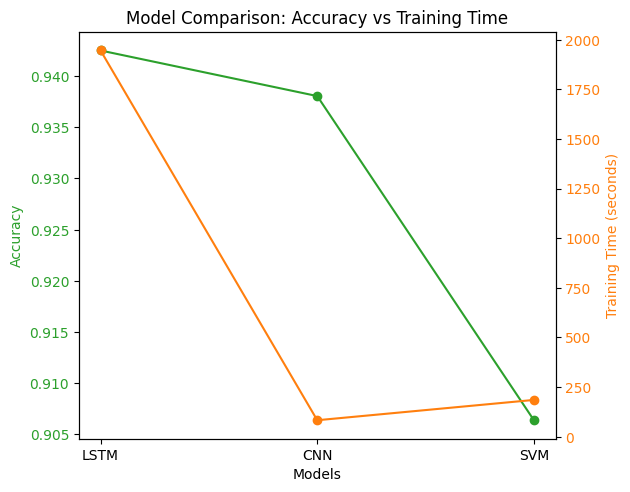

In [20]:

models = ['LSTM', 'CNN', 'SVM']
accuracies = [accuracy_score(y_test, y_pred_lstm_classes),
              accuracy_score(y_test, y_pred_cnn_classes),
              accuracy_svm]
training_times = [lstm_training_time, cnn_training_time, svm_training_time]

# Plotting accuracy vs time
fig, ax1 = plt.subplots()


ax1.set_xlabel('Models')
ax1.set_ylabel('Accuracy', color='tab:green')
ax1.plot(models, accuracies, color='tab:green', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:green')

ax2 = ax1.twinx()
ax2.set_ylabel('Training Time (seconds)', color='tab:orange')
ax2.plot(models, training_times, color='tab:orange', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Model Comparison: Accuracy vs Training Time')
plt.show()


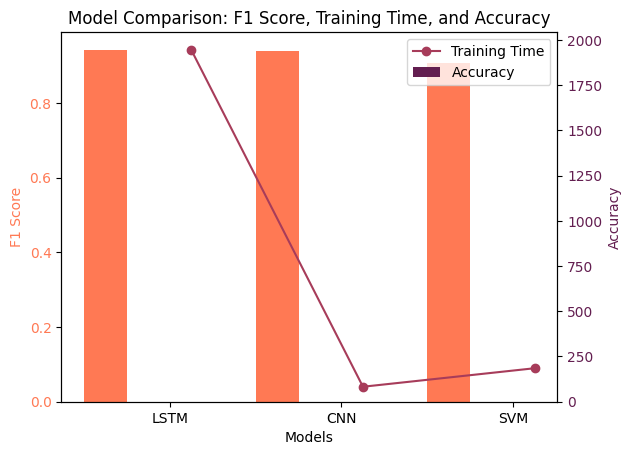

In [21]:

# Data for F1 Score, Training Time, and Accuracy
models = ['LSTM', 'CNN', 'SVM']
f1_values = [lstm_metrics['F1 Score'], cnn_metrics['F1 Score'], svm_metrics['F1 Score']]
training_times = [lstm_training_time, cnn_training_time, svm_training_time]
accuracies = [accuracy_score(y_test, y_pred_lstm_classes),
              accuracy_score(y_test, y_pred_cnn_classes),
              accuracy_svm]

bar_width = 0.25
index = np.arange(len(models))

# Create subplots
fig, ax1 = plt.subplots()

# Plot F1 Score on the first y-axis (left)
ax1.bar(index, f1_values, width=bar_width, label='F1 Score', color='#ff7954')
ax1.set_xlabel('Models')
ax1.set_ylabel('F1 Score', color='#ff7954')
ax1.tick_params(axis='y', labelcolor='#ff7954')

# Create a second y-axis (right) for Accuracy
ax2 = ax1.twinx()
ax2.bar(index + bar_width, accuracies, width=bar_width, label='Accuracy', color='#631e50')
ax2.set_ylabel('Accuracy', color='#631e50')
ax2.tick_params(axis='y', labelcolor='#631e50')

# Line chart for Training Time on the same graph
plt.plot(index + 2 * bar_width, training_times, marker='o', label='Training Time', color='#a73c5a')

# Adding labels and title
plt.xticks(index + 1.5 * bar_width, models)
plt.title('Model Comparison: F1 Score, Training Time, and Accuracy')
plt.legend()

# Display the plot
plt.show()


In [ ]:
# # Evaluate accuracy on the new data
# accuracy_lstm_new_data = accuracy_score(df_yelp['Fake_review_flag'], y_pred_lstm_classes_new_data)
# accuracy_cnn_new_data = accuracy_score(df_yelp['Fake_review_flag'], y_pred_cnn_classes_new_data)
# accuracy_svm_new_data = accuracy_score(df_yelp['Fake_review_flag'], y_pred_svm_new_data)

# # Print the accuracy on the new data
# print("LSTM Model Accuracy on New Data:", accuracy_lstm_new_data)
# print("CNN Model Accuracy on New Data:", accuracy_cnn_new_data)
# print("SVM Model Accuracy on New Data:", accuracy_svm_new_data)

In [22]:
# Hyperparameters
bert_batch_size = 32
roberta_batch_size = 32
distilbert_batch_size = 32
albert_batch_size = 32

bert_epochs = 4
roberta_epochs = 4
distilbert_epochs = 4
albert_epochs = 4

bert_max_len = 64
roberta_max_len = 64
distilbert_max_len = 64
albert_max_len = 64

In [23]:
# Function for BERT Tokenization
def bert_encode(data, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=bert_max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks


# Load the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize and encode sequences in the dataset
bert_train_input_ids, bert_train_attention_masks = bert_encode(X_train, bert_tokenizer, bert_max_len)
bert_test_input_ids, bert_test_attention_masks = bert_encode(X_test, bert_tokenizer, bert_max_len)

bert_train_labels = torch.tensor(y_train.values)
bert_test_labels = torch.tensor(y_test.values)

# Create the DataLoader for our training set
bert_train_data = TensorDataset(
    bert_train_input_ids, bert_train_attention_masks, bert_train_labels)
bert_train_sampler = RandomSampler(bert_train_data)
bert_train_dataloader = DataLoader(bert_train_data, sampler=bert_train_sampler, batch_size=bert_batch_size)

# Load the BERT model for sequence classification
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

# Optimizer
bert_optimizer = AdamW(bert_model.parameters(), lr=2e-5)

start_time = time.time()
# Training Loop
for epoch in range(bert_epochs):  # Number of training epochs
    bert_model.train()
    for step, batch in enumerate(bert_train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        bert_model.zero_grad()
        outputs = bert_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        bert_optimizer.step()

end_time = time.time()
bert_training_time = end_time - start_time

# Create the DataLoader for our test set
bert_test_data = TensorDataset(bert_test_input_ids, bert_test_attention_masks, bert_test_labels)
bert_test_sampler = SequentialSampler(bert_test_data)
bert_test_dataloader = DataLoader(bert_test_data, sampler=bert_test_sampler, batch_size=bert_batch_size)

# Prediction and Evaluation
bert_model.eval()
bert_predictions, bert_true_labels = [], []

for batch in bert_test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = bert_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    bert_predictions.append(logits)
    bert_true_labels.append(label_ids)

# Flatten the predictions and true values
bert_flat_predictions = np.concatenate(bert_predictions, axis=0)
bert_flat_predictions = np.argmax(bert_flat_predictions, axis=1).flatten()
bert_flat_true_labels = np.concatenate(bert_true_labels, axis=0)

# Print the classification report
print(classification_report(bert_flat_true_labels, bert_flat_predictions))

# Evaluate BERT
bert_accuracy = accuracy_score(bert_flat_true_labels, bert_flat_predictions)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(bert_flat_true_labels, bert_flat_predictions, average='weighted')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

  0%|          | 0/32345 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 8087/8087 [00:13<00:00, 608.37it/s]


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.94      0.97      4040
           1       0.95      0.99      0.97      4047

    accuracy                           0.97      8087
   macro avg       0.97      0.97      0.97      8087
weighted avg       0.97      0.97      0.97      8087



In [ ]:
# from torch.utils.data import DataLoader, TensorDataset, SequentialSampler

# # BERT
# bert_new_data_seq = bert_tokenizer(df_yelp['Reviews'].tolist(), padding=True, truncation=True, max_length=bert_max_len, return_tensors='pt')
# bert_new_data_labels = torch.tensor(df_yelp['Fake_review_flag'].values)

# # DataLoader for new data
# bert_new_data = TensorDataset(bert_new_data_seq['input_ids'], bert_new_data_seq['attention_mask'], bert_new_data_labels)
# bert_new_data_sampler = SequentialSampler(bert_new_data)
# bert_new_data_dataloader = DataLoader(bert_new_data, sampler=bert_new_data_sampler, batch_size=bert_batch_size)

# # Prediction and Evaluation for BERT
# bert_model.eval()
# bert_predictions_new_data, bert_true_labels_new_data = [], []

# for batch in bert_new_data_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask, b_labels = batch

#     with torch.no_grad():
#         outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

#     logits = outputs.logits
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to("cpu").numpy()

#     bert_predictions_new_data.append(logits)
#     bert_true_labels_new_data.append(label_ids)

# # Flatten the predictions and true values
# bert_flat_predictions_new_data = np.concatenate(bert_predictions_new_data, axis=0)
# bert_flat_predictions_new_data = np.argmax(bert_flat_predictions_new_data, axis=1).flatten()
# bert_flat_true_labels_new_data = np.concatenate(bert_true_labels_new_data, axis=0)

# # Print the classification report for BERT
# print("BERT Model Evaluation on New Data:")
# print(classification_report(bert_flat_true_labels_new_data, bert_flat_predictions_new_data))

# # Evaluate BERT on new data
# bert_accuracy_new_data = accuracy_score(bert_flat_true_labels_new_data, bert_flat_predictions_new_data)
# bert_precision_new_data, bert_recall_new_data, bert_f1_new_data, _ = precision_recall_fscore_support(bert_flat_true_labels_new_data, bert_flat_predictions_new_data, average='weighted')

# # Repeat the same process for RoBERTa, DistilBERT, and ALBERT models
# # ...



In [24]:
# Function for RoBERTa Tokenization
def roberta_encode(data, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=roberta_max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Load the tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tokenize and encode sequences in the dataset
roberta_train_input_ids, roberta_train_attention_masks = roberta_encode(X_train, roberta_tokenizer, roberta_max_len)
roberta_test_input_ids, roberta_test_attention_masks = roberta_encode(X_test, roberta_tokenizer, roberta_max_len)

roberta_train_labels = torch.tensor(y_train.values)
roberta_test_labels = torch.tensor(y_test.values)

# DataLoader for our training set
roberta_train_data = TensorDataset(roberta_train_input_ids, roberta_train_attention_masks, roberta_train_labels)
roberta_train_sampler = RandomSampler(roberta_train_data)
roberta_train_dataloader = DataLoader(roberta_train_data, sampler=roberta_train_sampler, batch_size=roberta_batch_size)

# Load the RoBERTa model
roberta_model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
roberta_model.to(device)

# Optimizer
roberta_optimizer = AdamW(roberta_model.parameters(), lr=2e-5)

start_time = time.time()
# Training Loop
for epoch in range(roberta_epochs):  # Number of training epochs
    roberta_model.train()
    for step, batch in enumerate(roberta_train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        roberta_model.zero_grad()
        outputs = roberta_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        roberta_optimizer.step()

end_time = time.time()
roberta_training_time = end_time - start_time

# Create the DataLoader for our test set
roberta_test_data = TensorDataset(roberta_test_input_ids, roberta_test_attention_masks, roberta_test_labels)
roberta_test_sampler = SequentialSampler(roberta_test_data)
roberta_test_dataloader = DataLoader(roberta_test_data, sampler=roberta_test_sampler, batch_size=roberta_batch_size)

# Prediction and Evaluation
roberta_model.eval()
roberta_predictions, roberta_true_labels = [], []

for batch in roberta_test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = roberta_model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    roberta_predictions.append(logits)
    roberta_true_labels.append(label_ids)

# Flatten the predictions and true values
roberta_flat_predictions = np.concatenate(roberta_predictions, axis=0)
roberta_flat_predictions = np.argmax(roberta_flat_predictions, axis=1).flatten()
roberta_flat_true_labels = np.concatenate(roberta_true_labels, axis=0)

# Print the classification report
print(classification_report(roberta_flat_true_labels, roberta_flat_predictions))

# Evaluate RoBERTa
roberta_accuracy = accuracy_score(roberta_flat_true_labels, roberta_flat_predictions)
roberta_precision, roberta_recall, roberta_f1, _ = precision_recall_fscore_support(roberta_flat_true_labels, roberta_flat_predictions, average='weighted')

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

  0%|          | 0/32345 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 8087/8087 [00:06<00:00, 1288.56it/s]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4040
           1       0.97      0.99      0.98      4047

    accuracy                           0.98      8087
   macro avg       0.98      0.98      0.98      8087
weighted avg       0.98      0.98      0.98      8087



In [ ]:
# # RoBERTa
# roberta_new_data_seq = roberta_tokenizer(df_yelp['Reviews'].tolist(), padding=True, truncation=True, max_length=roberta_max_len, return_tensors='pt')
# roberta_new_data_labels = torch.tensor(df_yelp['Fake_review_flag'].values)

# # DataLoader for new data
# roberta_new_data = TensorDataset(roberta_new_data_seq['input_ids'], roberta_new_data_seq['attention_mask'], roberta_new_data_labels)
# roberta_new_data_sampler = SequentialSampler(roberta_new_data)
# roberta_new_data_dataloader = DataLoader(roberta_new_data, sampler=roberta_new_data_sampler, batch_size=roberta_batch_size)

# # Prediction and Evaluation for RoBERTa
# roberta_model.eval()
# roberta_predictions_new_data, roberta_true_labels_new_data = [], []

# for batch in roberta_new_data_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask, b_labels = batch

#     with torch.no_grad():
#         outputs = roberta_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

#     logits = outputs.logits
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to("cpu").numpy()

#     roberta_predictions_new_data.append(logits)
#     roberta_true_labels_new_data.append(label_ids)

# # Flatten the predictions and true values
# roberta_flat_predictions_new_data = np.concatenate(roberta_predictions_new_data, axis=0)
# roberta_flat_predictions_new_data = np.argmax(roberta_flat_predictions_new_data, axis=1).flatten()
# roberta_flat_true_labels_new_data = np.concatenate(roberta_true_labels_new_data, axis=0)

# # Print the classification report for RoBERTa
# print("RoBERTa Model Evaluation on New Data:")
# print(classification_report(roberta_flat_true_labels_new_data, roberta_flat_predictions_new_data))

# # Evaluate RoBERTa on new data
# roberta_accuracy_new_data = accuracy_score(roberta_flat_true_labels_new_data, roberta_flat_predictions_new_data)
# roberta_precision_new_data, roberta_recall_new_data, roberta_f1_new_data, _ = precision_recall_fscore_support(roberta_flat_true_labels_new_data, roberta_flat_predictions_new_data, average='weighted')


In [25]:
# Function for DistilBERT Tokenization
def distilbert_encode(data, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=distilbert_max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Load the tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize and encode sequences in the dataset
max_len = 64
distilbert_train_input_ids, distilbert_train_attention_masks = distilbert_encode(X_train, distilbert_tokenizer, distilbert_max_len)
distilbert_test_input_ids, distilbert_test_attention_masks = distilbert_encode(X_test, distilbert_tokenizer, distilbert_max_len)

distilbert_train_labels = torch.tensor(y_train.values)
distilbert_test_labels = torch.tensor(y_test.values)

# DataLoader for our training set
distilbert_train_data = TensorDataset(distilbert_train_input_ids, distilbert_train_attention_masks, distilbert_train_labels)
distilbert_train_sampler = RandomSampler(distilbert_train_data)
distilbert_train_dataloader = DataLoader(distilbert_train_data, sampler=distilbert_train_sampler, batch_size=distilbert_batch_size)

# Load the DistilBERT model
distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
distilbert_model.to(device)

# Optimizer
distilbert_optimizer = AdamW(distilbert_model.parameters(), lr=2e-5)

start_time = time.time()

# Training Loop
for epoch in range(distilbert_epochs):  # Number of training epochs
    distilbert_model.train()
    for step, batch in enumerate(distilbert_train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        distilbert_model.zero_grad()
        outputs = distilbert_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        distilbert_optimizer.step()

end_time = time.time()
distilbert_training_time = end_time - start_time


# DataLoader for our test set
distilbert_test_data = TensorDataset(distilbert_test_input_ids, distilbert_test_attention_masks, distilbert_test_labels)
distilbert_test_sampler = SequentialSampler(distilbert_test_data)
distilbert_test_dataloader = DataLoader(distilbert_test_data, sampler=distilbert_test_sampler, batch_size=distilbert_batch_size)

# Prediction and Evaluation
distilbert_model.eval()
distilbert_predictions, distilbert_true_labels = [], []

for batch in distilbert_test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = distilbert_model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    distilbert_predictions.append(logits)
    distilbert_true_labels.append(label_ids)

# Flatten the predictions and true values
distilbert_flat_predictions = np.concatenate(distilbert_predictions, axis=0)
distilbert_flat_predictions = np.argmax(distilbert_flat_predictions, axis=1).flatten()
distilbert_flat_true_labels = np.concatenate(distilbert_true_labels, axis=0)

# Print the classification report
print(classification_report(distilbert_flat_true_labels, distilbert_flat_predictions))

# Evaluate DistilBERT
distilbert_accuracy = accuracy_score(distilbert_flat_true_labels, distilbert_flat_predictions)
distilbert_precision, distilbert_recall, distilbert_f1, _ = precision_recall_fscore_support(distilbert_flat_true_labels, distilbert_flat_predictions, average='weighted')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/32345 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 8087/8087 [00:13<00:00, 608.09it/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.95      0.97      4040
           1       0.95      0.99      0.97      4047

    accuracy                           0.97      8087
   macro avg       0.97      0.97      0.97      8087
weighted avg       0.97      0.97      0.97      8087



In [ ]:
# # DistilBERT
# distilbert_new_data_seq = distilbert_tokenizer(df_yelp['Reviews'].tolist(), padding=True, truncation=True, max_length=distilbert_max_len, return_tensors='pt')
# distilbert_new_data_labels = torch.tensor(df_yelp['Fake_review_flag'].values)

# # DataLoader for new data
# distilbert_new_data = TensorDataset(distilbert_new_data_seq['input_ids'], distilbert_new_data_seq['attention_mask'], distilbert_new_data_labels)
# distilbert_new_data_sampler = SequentialSampler(distilbert_new_data)
# distilbert_new_data_dataloader = DataLoader(distilbert_new_data, sampler=distilbert_new_data_sampler, batch_size=distilbert_batch_size)

# # Prediction and Evaluation for DistilBERT
# distilbert_model.eval()
# distilbert_predictions_new_data, distilbert_true_labels_new_data = [], []

# for batch in distilbert_new_data_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask, b_labels = batch

#     with torch.no_grad():
#         outputs = distilbert_model(b_input_ids, attention_mask=b_input_mask)

#     logits = outputs.logits
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to("cpu").numpy()

#     distilbert_predictions_new_data.append(logits)
#     distilbert_true_labels_new_data.append(label_ids)

# # Flatten the predictions and true values
# distilbert_flat_predictions_new_data = np.concatenate(distilbert_predictions_new_data, axis=0)
# distilbert_flat_predictions_new_data = np.argmax(distilbert_flat_predictions_new_data, axis=1).flatten()
# distilbert_flat_true_labels_new_data = np.concatenate(distilbert_true_labels_new_data, axis=0)

# # Print the classification report for DistilBERT
# print("DistilBERT Model Evaluation on New Data:")
# print(classification_report(distilbert_flat_true_labels_new_data, distilbert_flat_predictions_new_data))

# # Evaluate DistilBERT on new data
# distilbert_accuracy_new_data = accuracy_score(distilbert_flat_true_labels_new_data, distilbert_flat_predictions_new_data)
# distilbert_precision_new_data, distilbert_recall_new_data, distilbert_f1_new_data, _ = precision_recall_fscore_support(distilbert_flat_true_labels_new_data, distilbert_flat_predictions_new_data, average='weighted')


In [26]:
# Function for ALBERT Tokenization
def albert_encode(data, tokenizer, max_len):
    input_ids = []
    attention_masks = []

    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(
            data.iloc[i],
            add_special_tokens=True,
            max_length=albert_max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Load the tokenizer
albert_tokenizer = AlbertTokenizer.from_pretrained("albert-base-v2")

# Tokenize and encode sequences in the dataset
albert_train_input_ids, albert_train_attention_masks = albert_encode(X_train, albert_tokenizer, albert_max_len)
albert_test_input_ids, albert_test_attention_masks = albert_encode(X_test, albert_tokenizer, albert_max_len)

albert_train_labels = torch.tensor(y_train.values)
albert_test_labels = torch.tensor(y_test.values)

# DataLoader for our training set
albert_train_data = TensorDataset(albert_train_input_ids, albert_train_attention_masks, albert_train_labels)
albert_train_sampler = RandomSampler(albert_train_data)
albert_train_dataloader = DataLoader(albert_train_data, sampler=albert_train_sampler, batch_size=albert_batch_size)

# Load the ALBERT model
albert_model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
albert_model.to(device)

# Optimizer
albert_optimizer = AdamW(albert_model.parameters(), lr=2e-5)

start_time = time.time()
# Training Loop
for epoch in range(albert_epochs):  # Number of training epochs
    albert_model.train()
    for step, batch in enumerate(albert_train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)

        albert_model.zero_grad()
        outputs = albert_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        albert_optimizer.step()

end_time = time.time()
albert_training_time = end_time - start_time

# DataLoader for our test set
albert_test_data = TensorDataset(albert_test_input_ids, albert_test_attention_masks, albert_test_labels)
albert_test_sampler = SequentialSampler(albert_test_data)
albert_test_dataloader = DataLoader(albert_test_data, sampler=albert_test_sampler, batch_size=albert_batch_size)

# Prediction and Evaluation
albert_model.eval()
albert_predictions, albert_true_labels = [], []

for batch in albert_test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = albert_model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    albert_predictions.append(logits)
    albert_true_labels.append(label_ids)

# Flatten the predictions and true values
albert_flat_predictions = np.concatenate(albert_predictions, axis=0)
albert_flat_predictions = np.argmax(albert_flat_predictions, axis=1).flatten()
albert_flat_true_labels = np.concatenate(albert_true_labels, axis=0)

# Print the classification report
print(classification_report(albert_flat_true_labels, albert_flat_predictions))

# Evaluate ALBERT
albert_accuracy = accuracy_score(albert_flat_true_labels, albert_flat_predictions)
albert_precision, albert_recall, albert_f1, _ = precision_recall_fscore_support(albert_flat_true_labels, albert_flat_predictions, average='weighted')


spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

  0%|          | 0/32345 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 8087/8087 [00:07<00:00, 1016.86it/s]


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.95      0.97      4040
           1       0.95      0.99      0.97      4047

    accuracy                           0.97      8087
   macro avg       0.97      0.97      0.97      8087
weighted avg       0.97      0.97      0.97      8087



In [ ]:
# # ALBERT
# albert_new_data_seq = albert_tokenizer(df_yelp['Reviews'].tolist(), padding=True, truncation=True, max_length=albert_max_len, return_tensors='pt')
# albert_new_data_labels = torch.tensor(df_yelp['Fake_review_flag'].values)

# # DataLoader for new data
# albert_new_data = TensorDataset(albert_new_data_seq['input_ids'], albert_new_data_seq['attention_mask'], albert_new_data_labels)
# albert_new_data_sampler = SequentialSampler(albert_new_data)
# albert_new_data_dataloader = DataLoader(albert_new_data, sampler=albert_new_data_sampler, batch_size=albert_batch_size)

# # Prediction and Evaluation for ALBERT
# albert_model.eval()
# albert_predictions_new_data, albert_true_labels_new_data = [], []

# for batch in albert_new_data_dataloader:
#     batch = tuple(t.to(device) for t in batch)
#     b_input_ids, b_input_mask, b_labels = batch

#     with torch.no_grad():
#         outputs = albert_model(b_input_ids, attention_mask=b_input_mask)

#     logits = outputs.logits
#     logits = logits.detach().cpu().numpy()
#     label_ids = b_labels.to("cpu").numpy()

#     albert_predictions_new_data.append(logits)
#     albert_true_labels_new_data.append(label_ids)

# # Flatten the predictions and true values
# albert_flat_predictions_new_data = np.concatenate(albert_predictions_new_data, axis=0)
# albert_flat_predictions_new_data = np.argmax(albert_flat_predictions_new_data, axis=1).flatten()
# albert_flat_true_labels_new_data = np.concatenate(albert_true_labels_new_data, axis=0)

# # Print the classification report for ALBERT
# print("ALBERT Model Evaluation on New Data:")
# print(classification_report(albert_flat_true_labels_new_data, albert_flat_predictions_new_data))

# # Evaluate ALBERT on new data
# albert_accuracy_new_data = accuracy_score(albert_flat_true_labels_new_data, albert_flat_predictions_new_data)
# albert_precision_new_data, albert_recall_new_data, albert_f1_new_data, _ = precision_recall_fscore_support(albert_flat_true_labels_new_data, albert_flat_predictions_new_data, average='weighted')


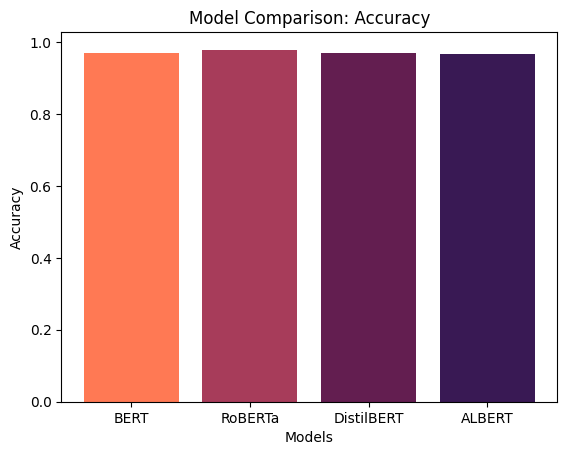

In [27]:
# Create a bar chart for accuracy
models = ['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT']
accuracies = [bert_accuracy, roberta_accuracy, distilbert_accuracy, albert_accuracy]

plt.bar(models, accuracies, color=['#ff7954', '#a73c5a', '#631e50', '#391954'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.show()


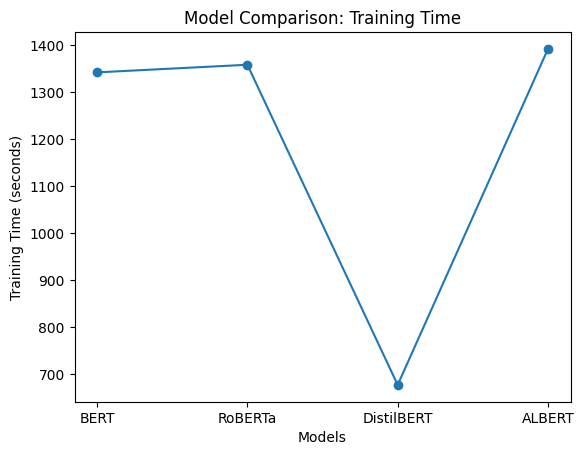

In [28]:
# Create a line chart for computational time
training_times = [bert_training_time, roberta_training_time, distilbert_training_time, albert_training_time]

plt.plot(models, training_times, marker='o')
plt.xlabel('Models')
plt.ylabel('Training Time (seconds)')
plt.title('Model Comparison: Training Time')
plt.show()


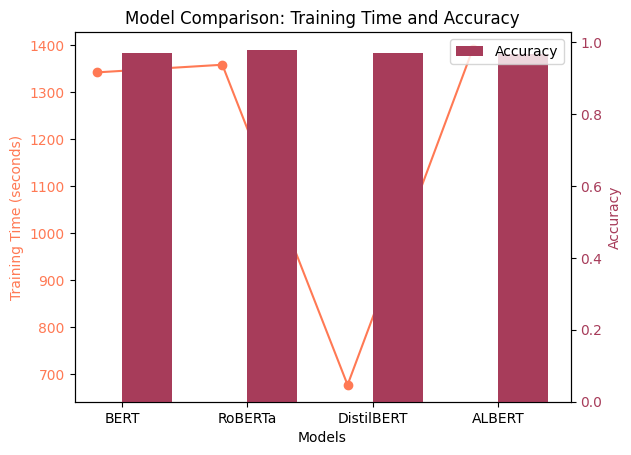

In [29]:
# Data for training time and accuracy
models = ['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT']
training_times = [bert_training_time, roberta_training_time, distilbert_training_time, albert_training_time]
accuracies = [bert_accuracy, roberta_accuracy, distilbert_accuracy, albert_accuracy]

bar_width = 0.4
index = np.arange(len(models))

# Create subplots
fig, ax1 = plt.subplots()

# Plot training time on the first y-axis (left)
ax1.plot(index, training_times, marker='o', label='Training Time', color='#ff7954')
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (seconds)', color='#ff7954')
ax1.tick_params(axis='y', labelcolor='#ff7954')

# Create a second y-axis (right) for accuracy
ax2 = ax1.twinx()
ax2.bar(index + bar_width, accuracies, width=bar_width, label='Accuracy', color='#a73c5a')
ax2.set_ylabel('Accuracy', color='#a73c5a')
ax2.tick_params(axis='y', labelcolor='#a73c5a')

# Adding labels and title
plt.xticks(index + bar_width / 2, models)
plt.title('Model Comparison: Training Time and Accuracy')
plt.legend()

# Display the plot
plt.show()

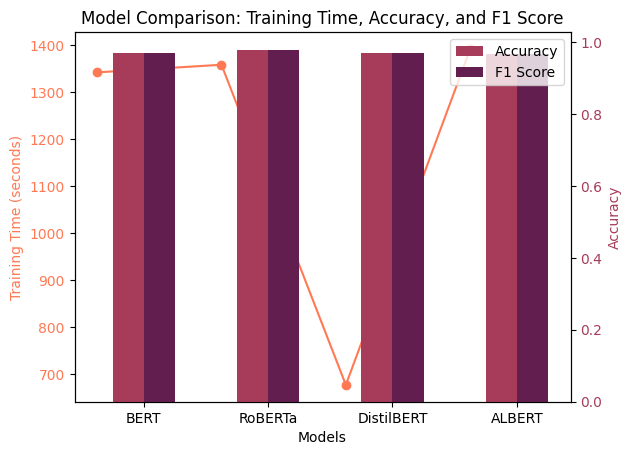

In [30]:

# Data for training time, accuracy, and F1 score
models = ['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT']
training_times = [bert_training_time, roberta_training_time, distilbert_training_time, albert_training_time]
accuracies = [bert_accuracy, roberta_accuracy, distilbert_accuracy, albert_accuracy]
f1_scores = [bert_f1, roberta_f1, distilbert_f1, albert_f1]

bar_width = 0.25
index = np.arange(len(models))

# Create subplots
fig, ax1 = plt.subplots()

# Plot training time on the first y-axis (left)
ax1.plot(index, training_times, marker='o', label='Training Time', color='#ff7954')
ax1.set_xlabel('Models')
ax1.set_ylabel('Training Time (seconds)', color='#ff7954')
ax1.tick_params(axis='y', labelcolor='#ff7954')

# Create a second y-axis (right) for accuracy
ax2 = ax1.twinx()
ax2.bar(index + bar_width, accuracies, width=bar_width, label='Accuracy', color='#a73c5a')
ax2.set_ylabel('Accuracy', color='#a73c5a')
ax2.tick_params(axis='y', labelcolor='#a73c5a')

# Plot F1 score on the same graph
plt.bar(index + 2 * bar_width, f1_scores, width=bar_width, label='F1 Score', color='#631e50')

# Adding labels and title
plt.xticks(index + 1.5 * bar_width, models)
plt.title('Model Comparison: Training Time, Accuracy, and F1 Score')
plt.legend()

# Display the plot
plt.show()


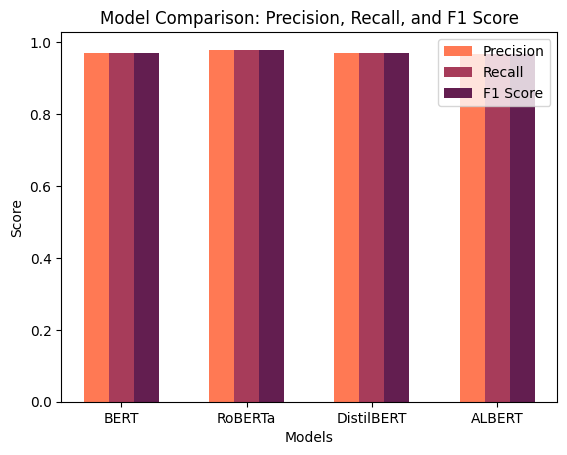

In [31]:

# Data for precision, recall, and F1 score
precision_values = [bert_precision, roberta_precision, distilbert_precision, albert_precision]
recall_values = [bert_recall, roberta_recall, distilbert_recall, albert_recall]
f1_values = [bert_f1, roberta_f1, distilbert_f1, albert_f1]

bar_width = 0.2
index = np.arange(len(models))

# Plotting the metrics in a single bar chart
plt.bar(index - bar_width, precision_values, width=bar_width, label='Precision', color='#ff7954')
plt.bar(index, recall_values, width=bar_width, label='Recall', color='#a73c5a')
plt.bar(index + bar_width, f1_values, width=bar_width, label='F1 Score', color='#631e50')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Comparison: Precision, Recall, and F1 Score')
plt.xticks(index, models)
plt.legend()

# Display the plot
plt.show()



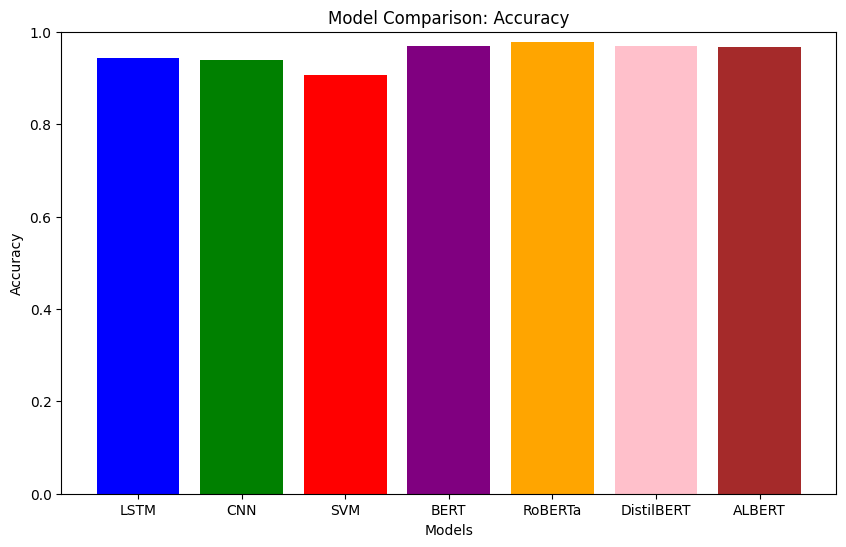

In [32]:

# Define the models and their accuracies
models = ['LSTM', 'CNN', 'SVM', 'BERT', 'RoBERTa', 'DistilBERT', 'ALBERT']
accuracies = [accuracy_lstm, accuracy_cnn, accuracy_svm, bert_accuracy, roberta_accuracy, distilbert_accuracy, albert_accuracy]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange', 'pink', 'brown'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.ylim(0, 1.0)  # Set the y-axis range between 0 and 1 for accuracy
plt.show()


In [ ]:
# # Tokenize the new data
# new_data_seq = tokenizer.texts_to_sequences(df_yelp['Reviews'])
# new_data_pad = pad_sequences(new_data_seq, maxlen=maxlen)

# # Predictions with LSTM model
# y_pred_lstm_classes_new_data = (lstm_model.predict(new_data_pad) > 0.5).astype("int32")
# # Predictions with CNN model
# y_pred_cnn_classes_new_data = (cnn_model.predict(new_data_pad) > 0.5).astype("int32")


In [ ]:

# # Predictions with SVM model
# new_data_tfidf = vectorizer.transform(df_yelp['Reviews'])
# y_pred_svm_new_data = svm_model.predict(new_data_tfidf)